# Plot processes

The WPS flyingpigeon provides several processes to perform plot subsetts of netCDF files.

They are several processes to perfom timeseries graphics as well as spatial visualisations as maps. 

In [1]:
# birdy client for communication with the server:
from birdy import WPSClient
# import birdy 

# handling files and folders
from os import path, listdir
from urllib import request
import time

# to display external png graphics in notebook: 
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
# on serverside :
# conda activate finch 
# finch start -c etc/custom.cfg 

fp_server = 'http://localhost:8093/wps'    # flyingpigeon
fp_i = WPSClient(fp_server, progress=True)
fp = WPSClient(fp_server)


**read in the required files:**

this is an example of an local installation, where local files are processed
 
indices were calculated with the birdhouse WPS finch:
https://finch.readthedocs.io/en/latest/processes.html

In [3]:
# read in the existing indices based on bias_adjusted tas files:
tas_bbox = '/home/nils/nap_niger/data/adjust/indices/'
tasInd_bbox = [ tas_bbox+f for f in listdir(tas_bbox) if '.nc' in f ]
tas_NER = '/home/nils/nap_niger/data/adjust/NER/'
tasInd_NER = [ tas_NER+f for f in listdir(tas_NER) if '.nc' in f ]

# read in the existing Indices based on pr files (!!! not bias adjusted, so far !!!):
pr_bbox = '/home/nils/nap_niger/data/bbox/indices/'
prInd_bbox = [ pr_bbox+f for f in listdir(pr_bbox) if '.nc' in f ]
pr_NER = '/home/nils/nap_niger/data/bbox/NER/'
prInd_NER = [ pr_NER+f for f in listdir(pr_NER) if '.nc' in f ]


tasInd_NER.sort()
tasInd_bbox.sort()
prInd_bbox.sort()
prInd_NER.sort()

In [4]:
# frequencies
freq=['yr','mon']

# precipitation indices
pr_indices = ['prcptot','rx1day','wetdays','cdd','cwd','sdii','rx5day']
tas_indices = ['tg-mean']

titles = ['Somme annuelle des précipitations', 
          'Jours de plus fortes précipitations',
          'Nombre de jours humide',
          'Journées consécutives de sécheresse', 
          'Jours humides consécutifs', 
          "Index d'intensité de précipitations", 
          'Somme max. sur 5 jours consécutifs', 
          'Températures moyennes annuelles']

dates = ['1976-01-01', '2005-12-31', '2036-01-01', '2065-12-31', '2071-01-01', '2099-12-30']

In [14]:
# find ensemble files for one indice based on pr files:

tas_NER = '/home/nils/nap_niger/data/adjust/NER/'
tasInd_NER = [ tas_NER+f for f in listdir(tas_NER) if '.nc' in f ]

pr_NER = '/home/nils/nap_niger/data/bbox/NER/'
prInd_NER = [ pr_NER+f for f in listdir(pr_NER) if '.nc' in f ]

i = 1
indicie = pr_indices[i]

resource = [f for f in prInd_NER if indicie in f ] # and '_yr_' in f


#### Spaghetti Plot

A simple way of visualisation of an ensemble of datasets. The plot visualises historical and rcp runs in different colors 

In [15]:
out = fp_i.plot_spaghetti(resource=resource, # title=titles[i], # delta = -273.15,
                           # figsize='9,5',# ymin=0, ymax=14  # 
                         )

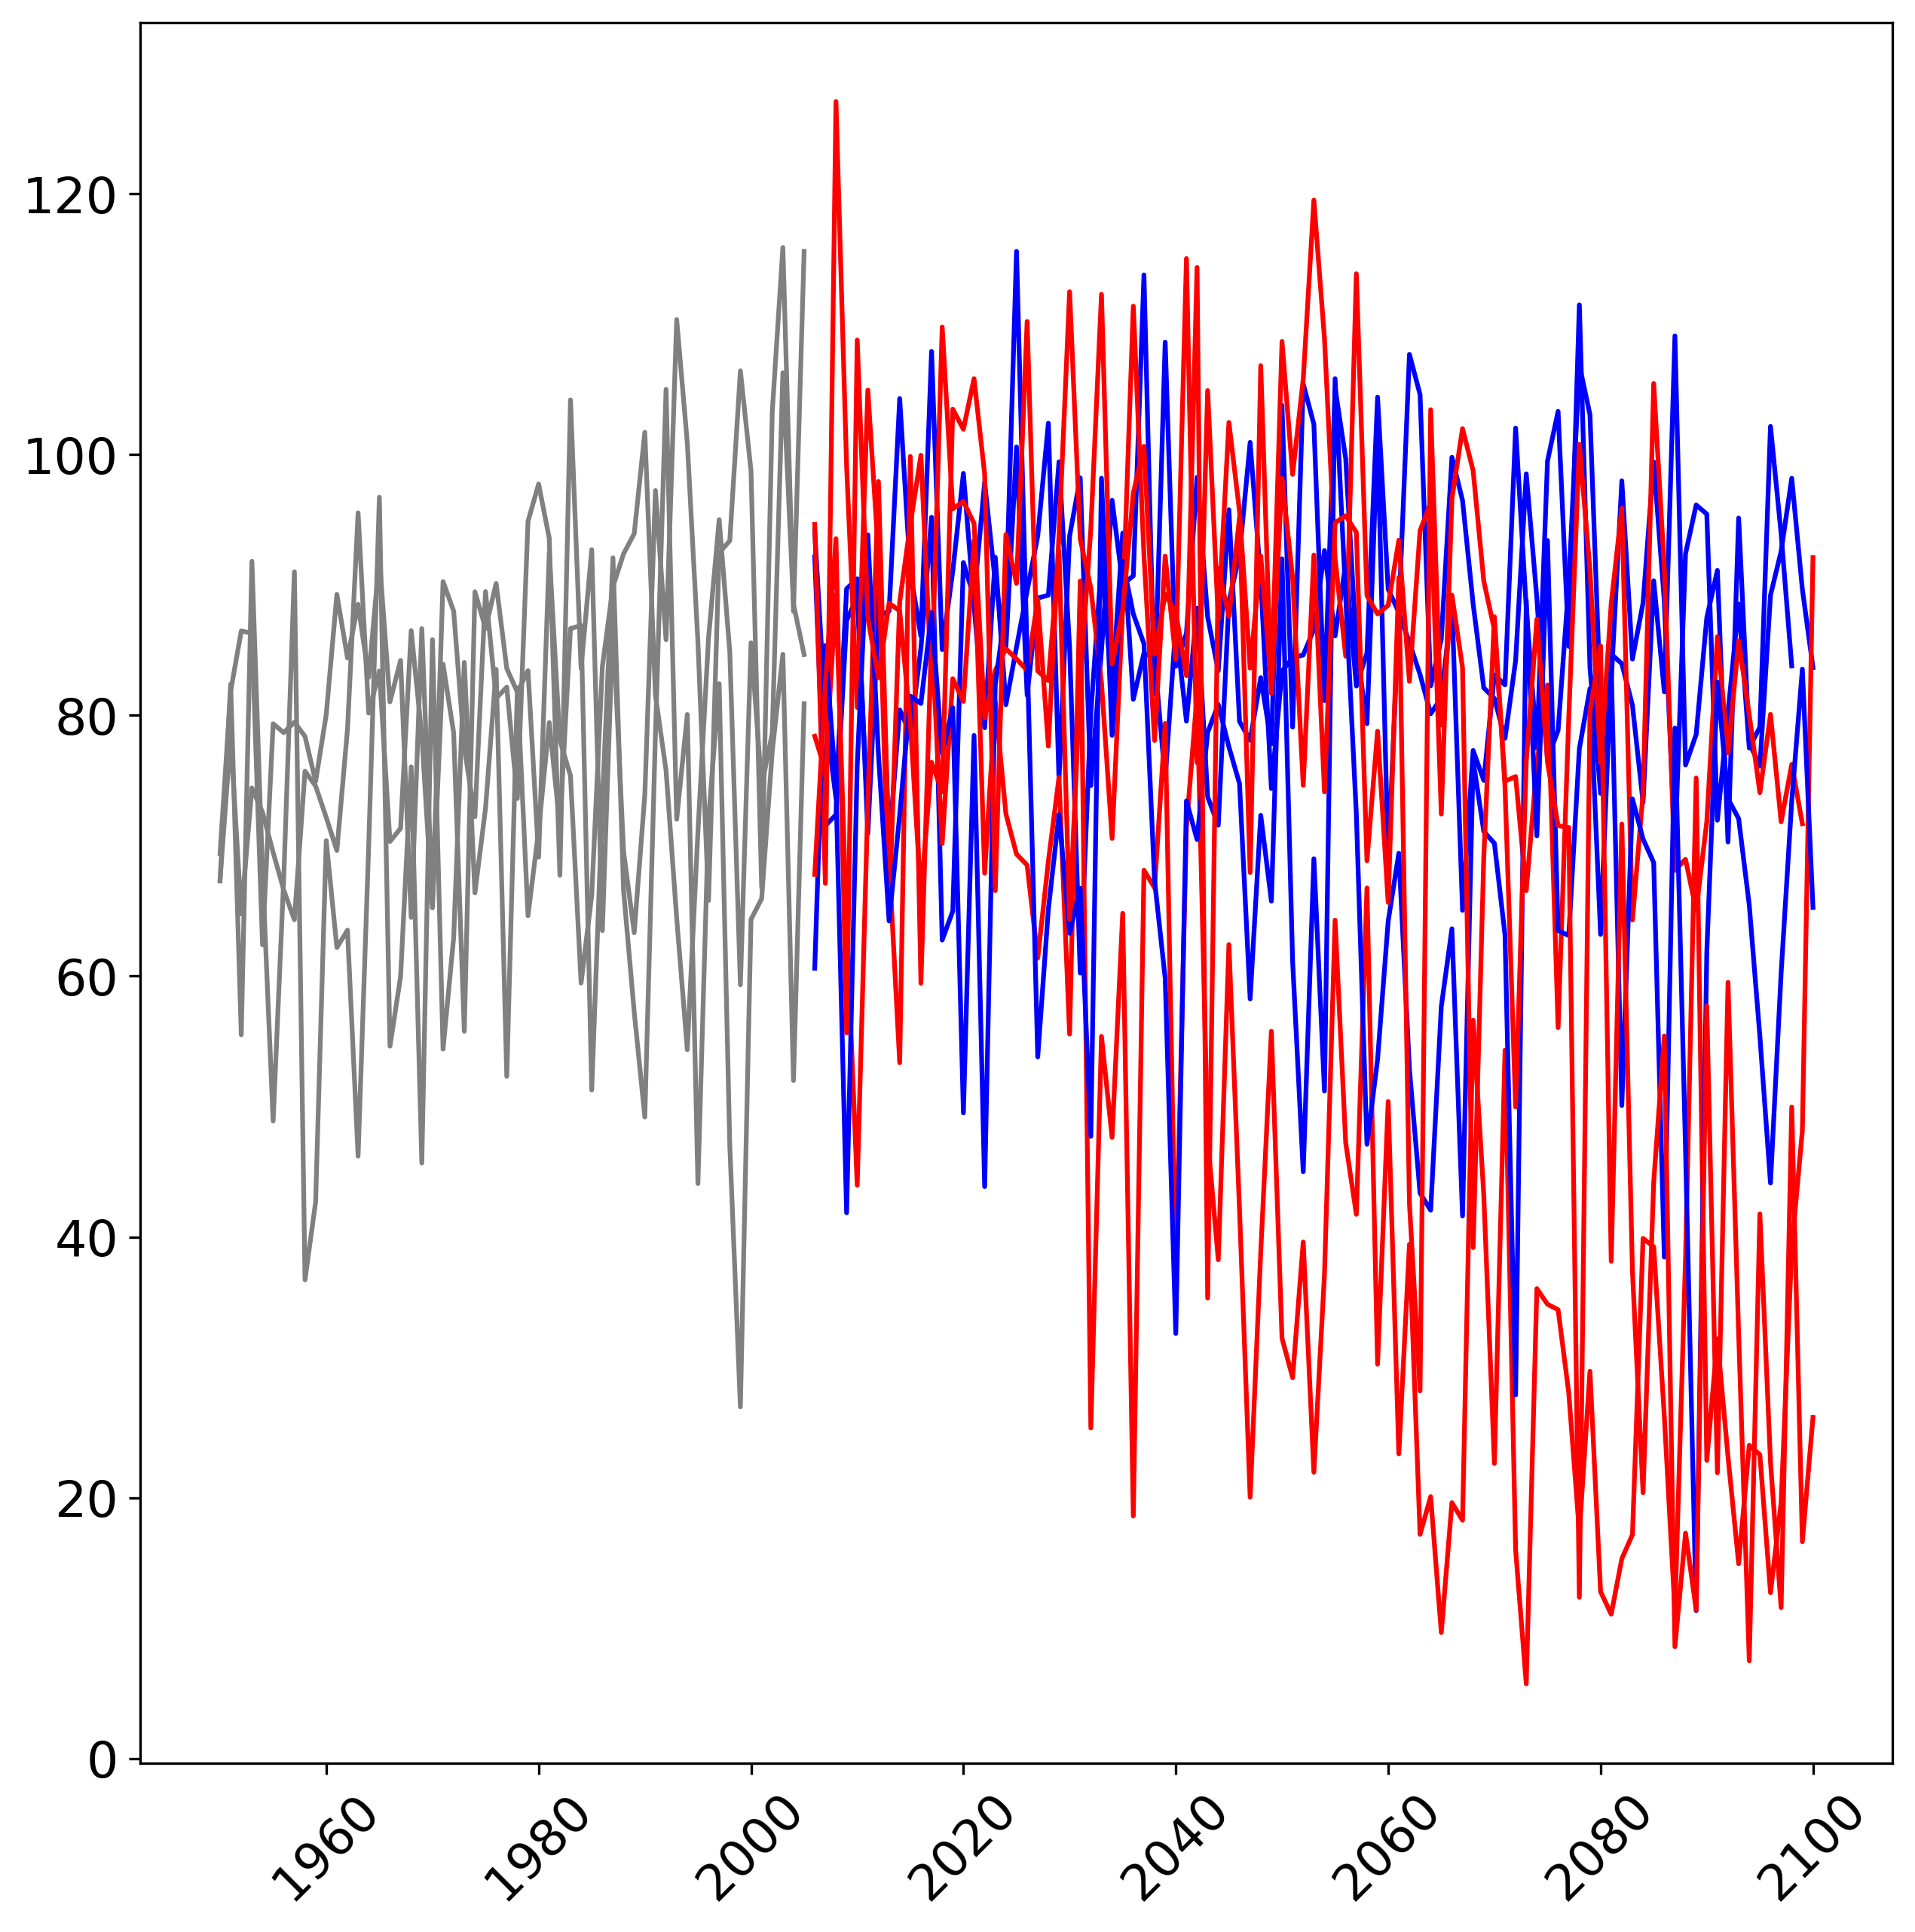

In [16]:
# display the output graphic url:
Image(out.get()[0], width=400)

#### RCP uncertainty timeseries

An ensemble of indice files will be visualised as median and the appropriate uncertainties seperatled by historical and rcp runs. 

In [17]:
out = fp_i.plot_uncertaintyrcp(resource=resource, title=titles[i], # delta = -273.15,
                            figsize='9,5', # ymin=20, ymax=100  # 
                           )

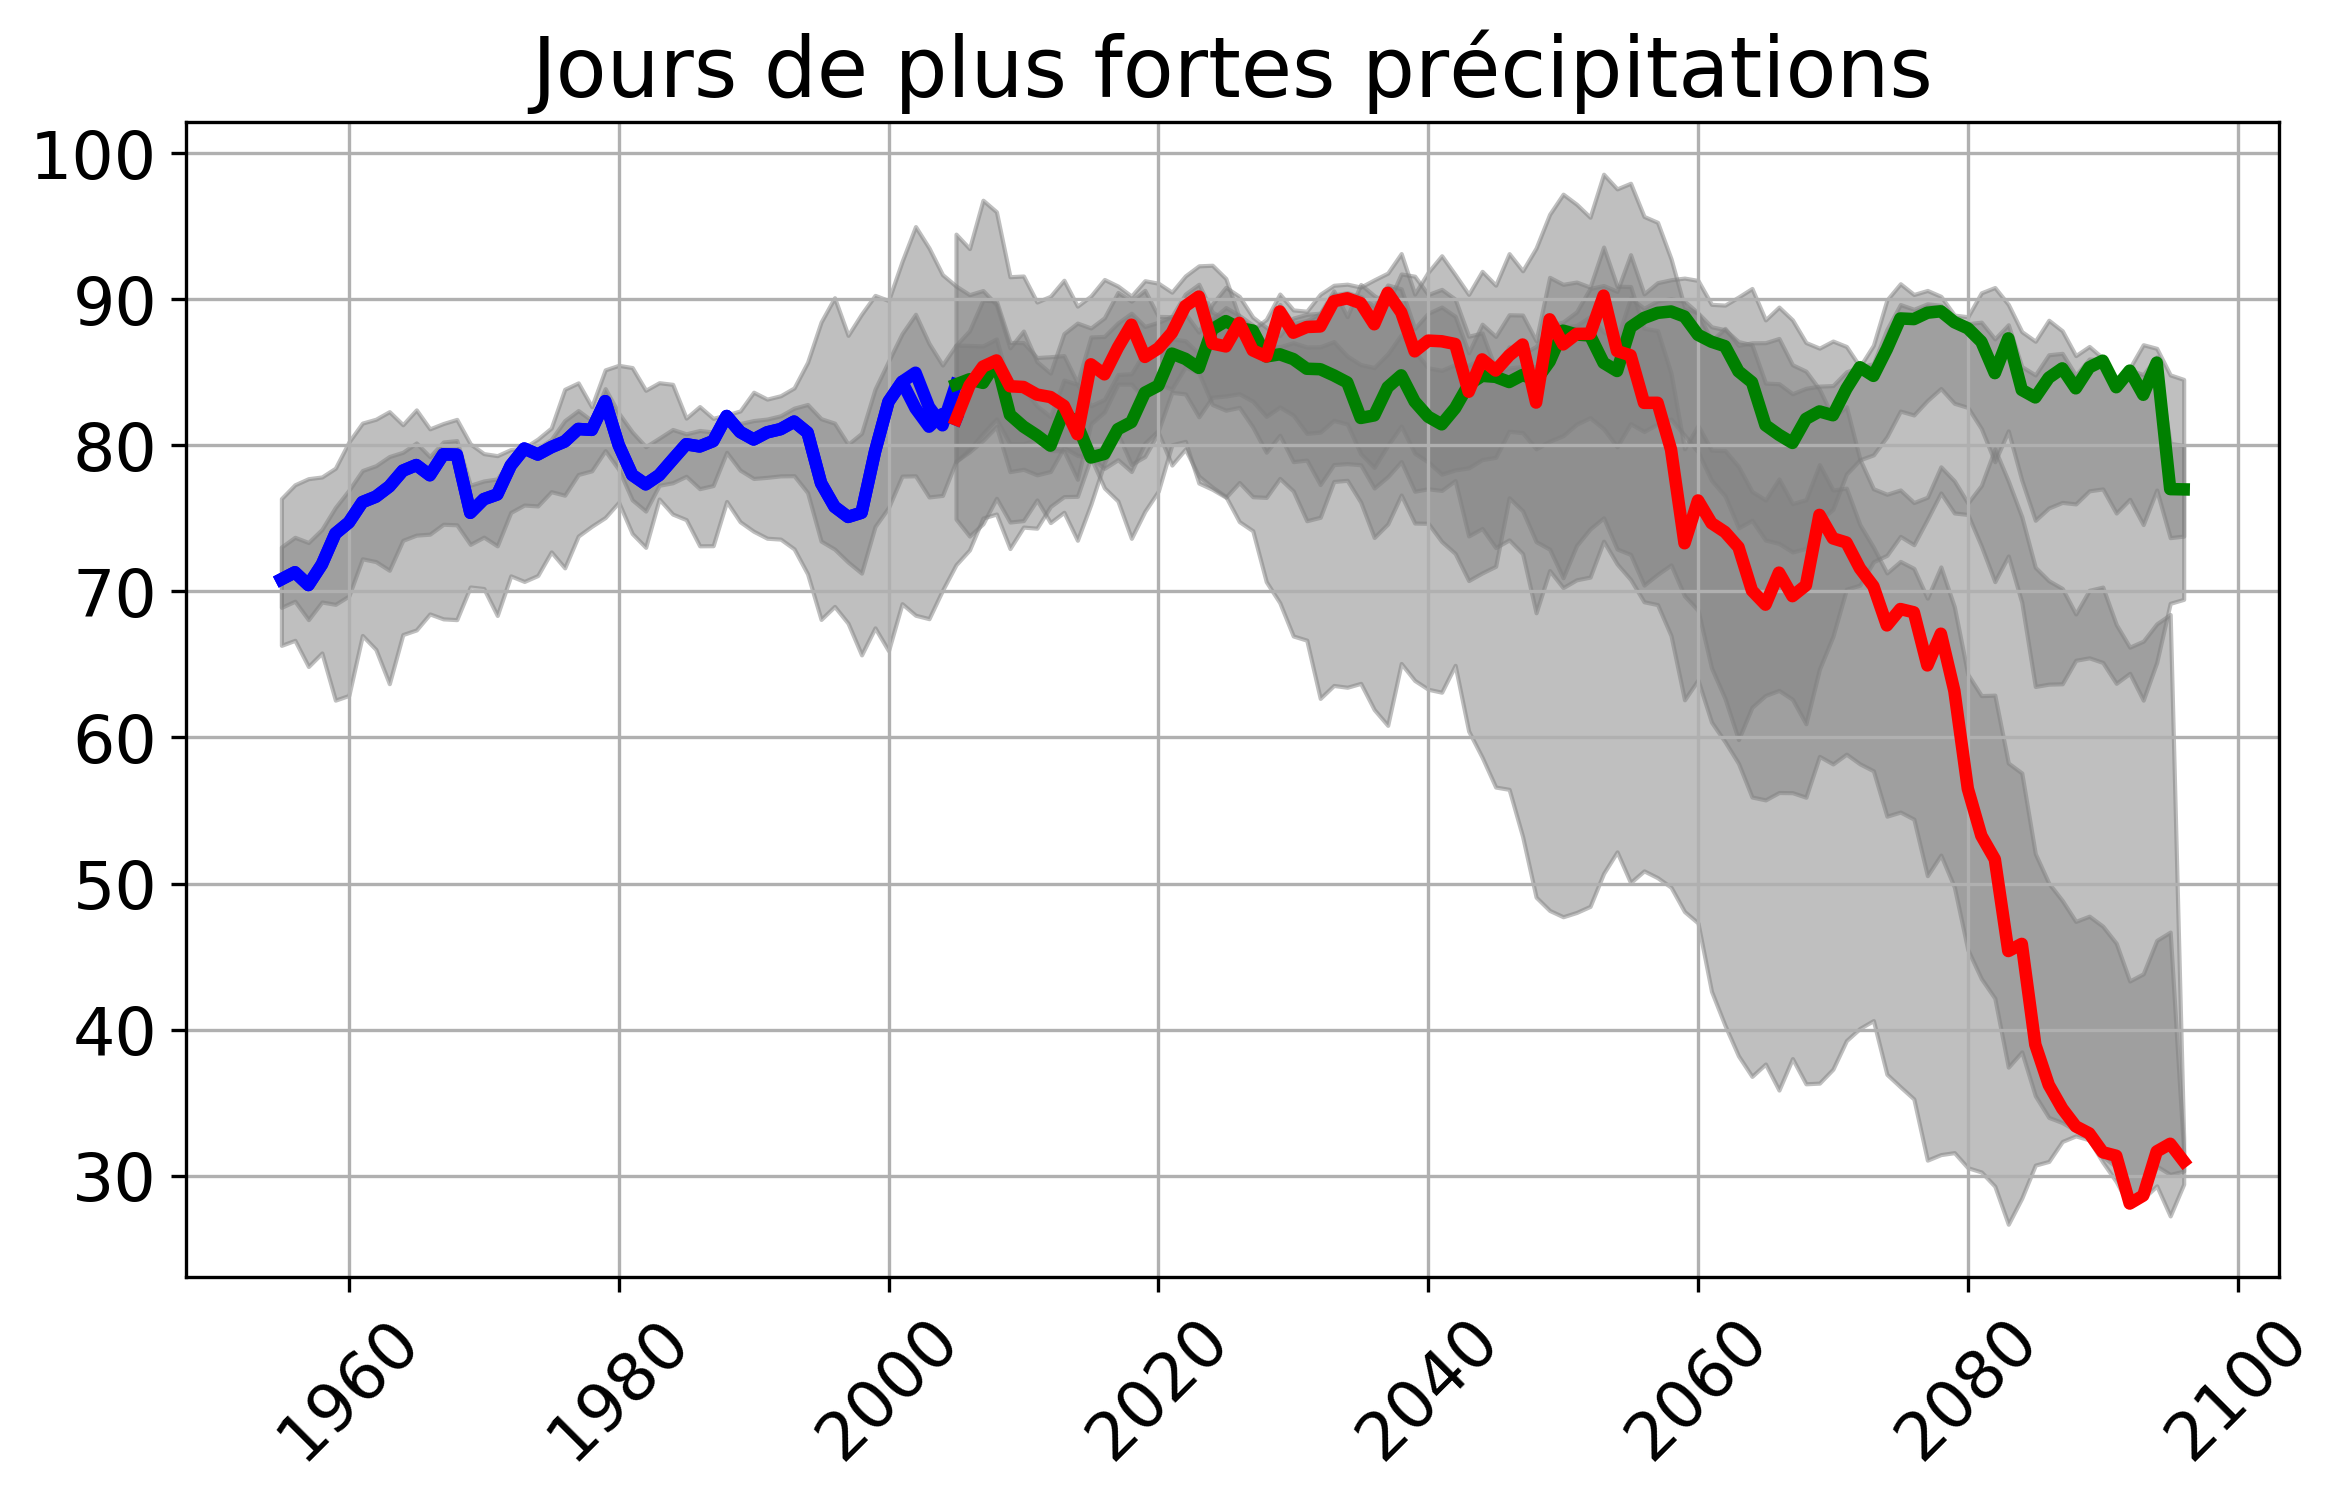

In [18]:
# one way to display the output graphic.

# download the file 
out_file = '/home/nils/data/ts_uncertainty_{}.png'.format(indicie)
request.urlretrieve(out.get()[0], out_file)

# display the graphic:
Image(out_file, width=400)

#### Plot a map

Spatial visualisation of data as a mean over the time. 

In [19]:
# select only the historical runs of the indices ensemble
hist = [f for f in resource if 'historical' in f]

# process the data of the years 1971-2000
out = fp_i.plot_map_timemean(resource=hist, title='Référnence historique (1971-2000)',
                             vmin=0,  vmax=130, # figsize='7,7', # delta = -273.15,
                             datestart='1971-01-01', dateend='2000-12-31',
                             cmap='Blues') # 


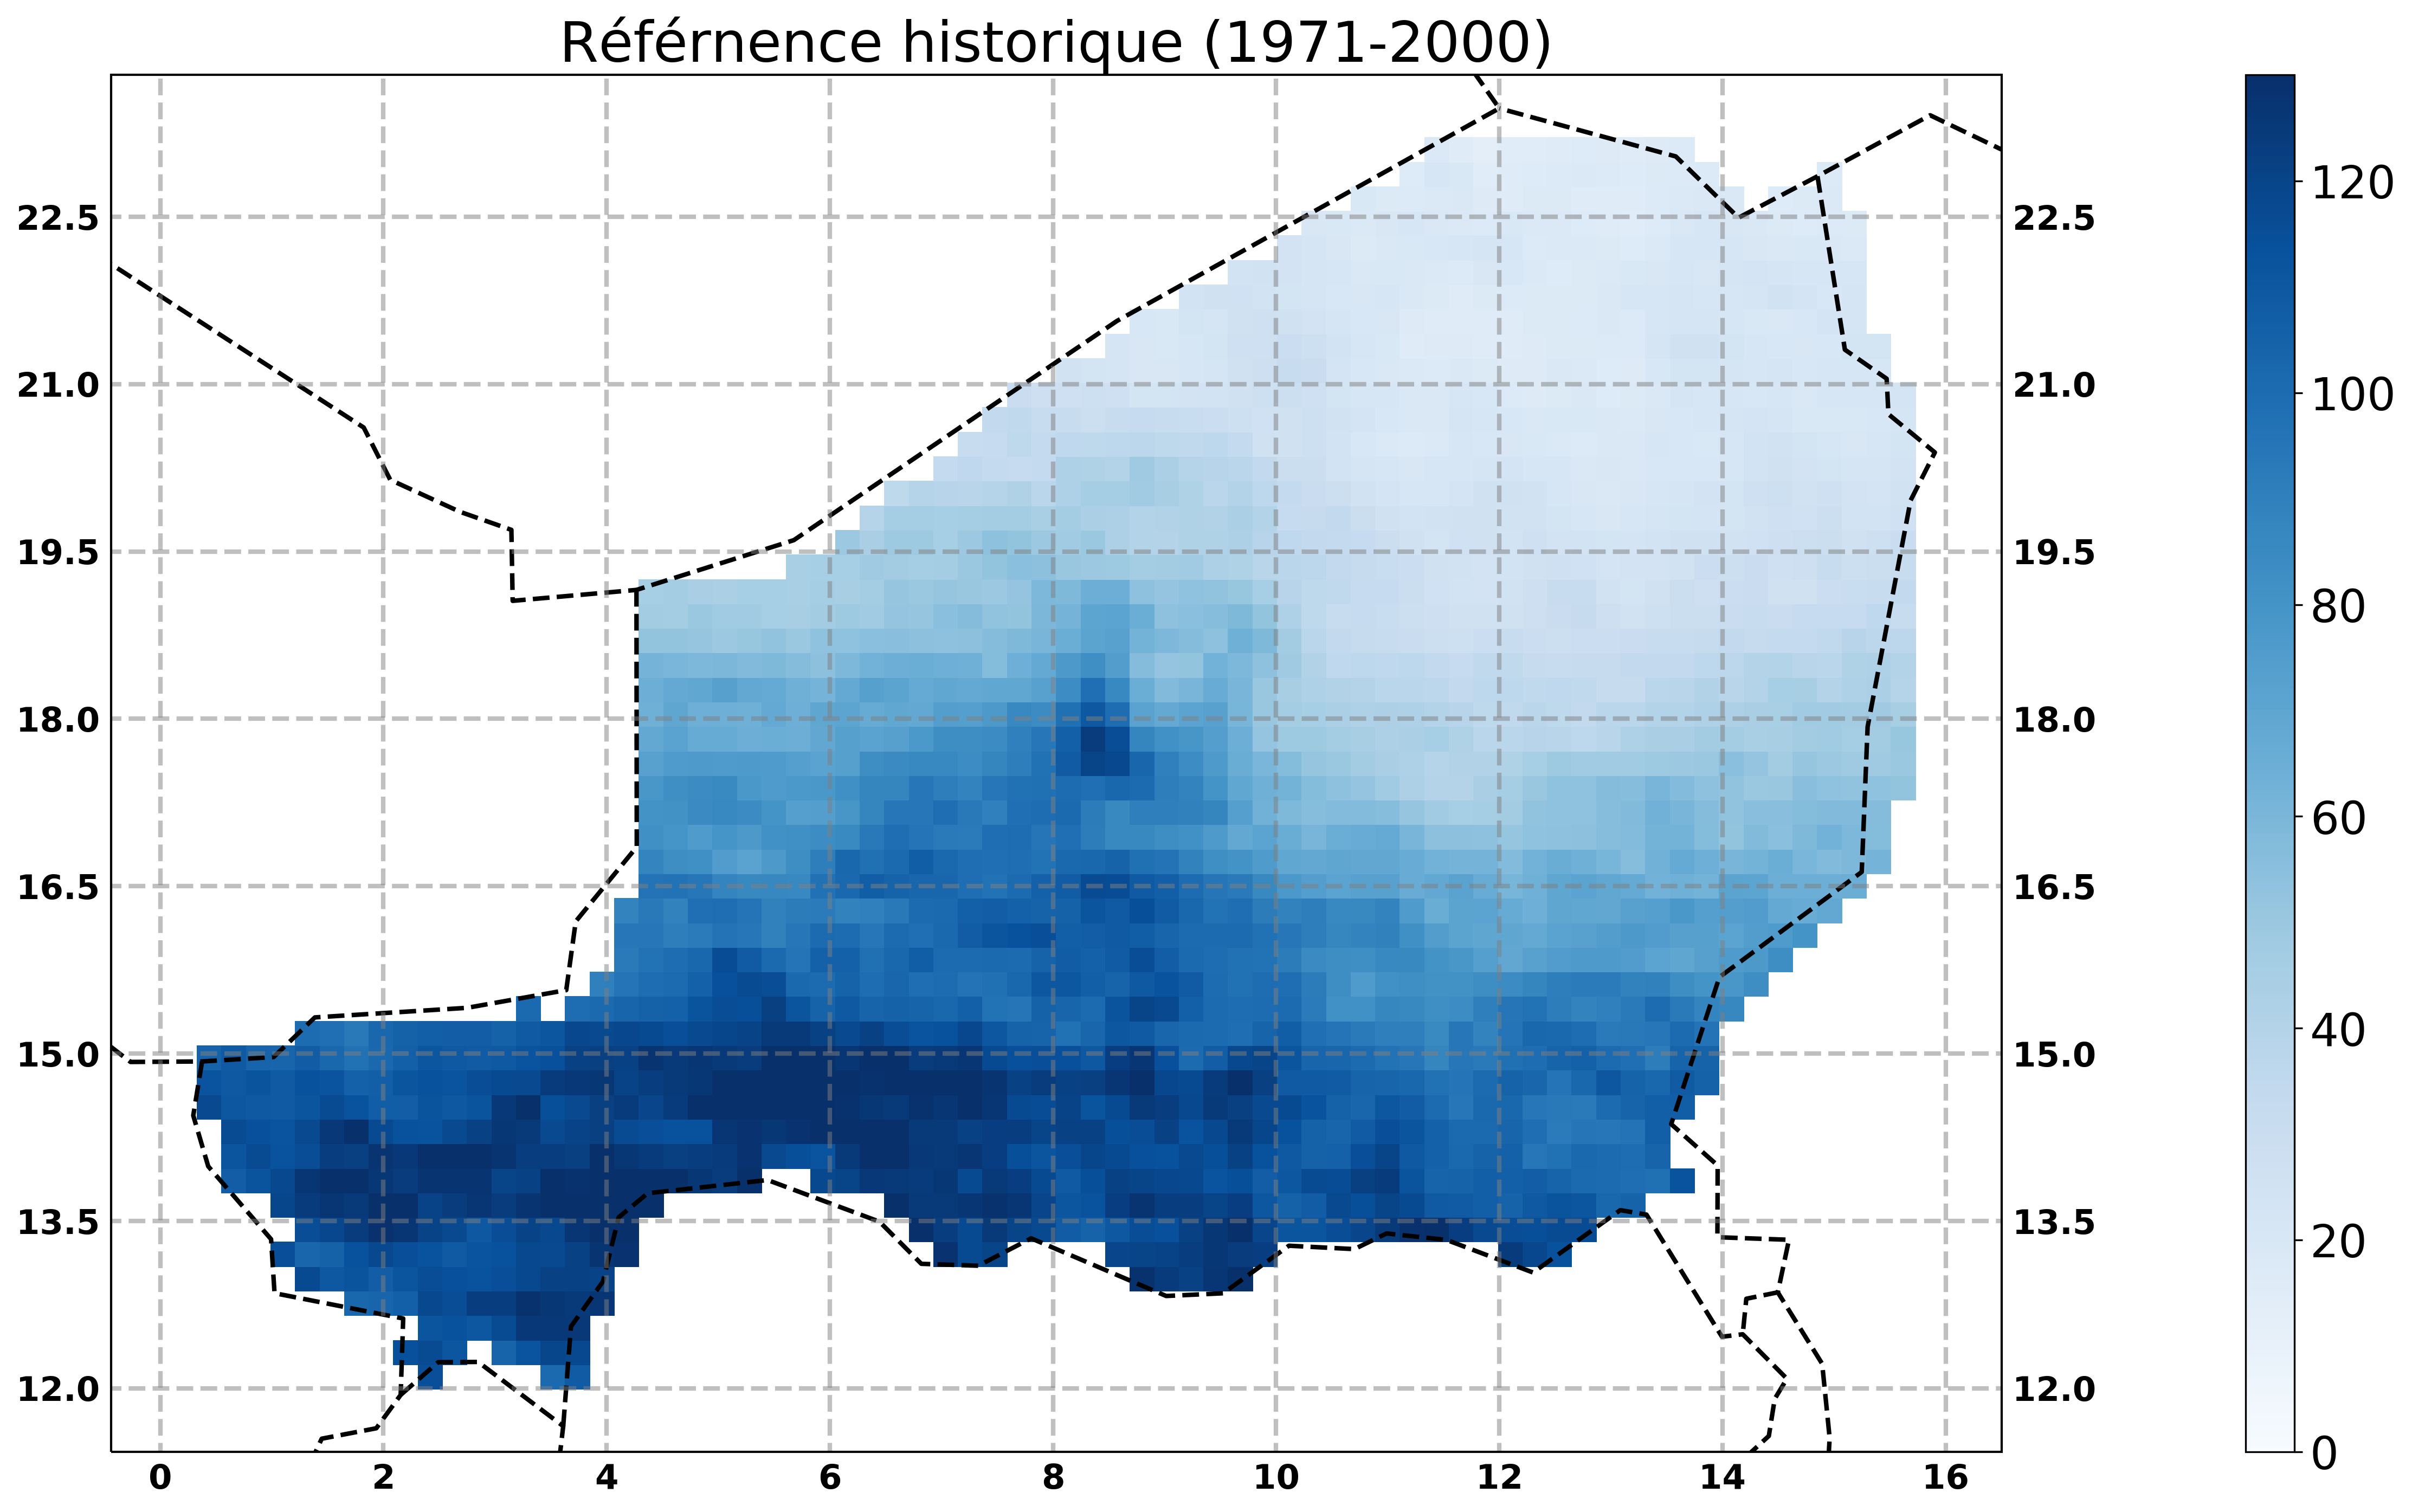

In [20]:
# display the output graphic
Image(out.get()[0], width=400)


#### plot a climate change signal

calculation of the differnence in a climate signal between a future projection to a reference periode 

In [27]:
# read in the existing Indices based on pr files (!!! not bias adjusted, so far !!!):
pr_bbox = '/home/nils/nap_niger/data/bbox/indices/'
prInd_bbox = [ pr_bbox+f for f in listdir(pr_bbox) if '.nc' in f ]
pr_NER = '/home/nils/nap_niger/data/NER/indices/'
prInd_NER = [ pr_NER+f for f in listdir(pr_NER) if '.nc' in f ]

# tas_bbox = '/home/nils/nap_niger/data/adjust/indices/'
# tasInd_bbox = [ tas_bbox+f for f in listdir(tas_bbox) if '.nc' in f ]

futures = ['2036-2065', '2071-2100']
dates = ['1971-01-01', '2000-12-31', '2036-01-01', '2065-12-31', '2071-01-01', '2100-12-31']

pr_indices = ['prcptot','rx1day','wetdays','cdd','cwd','sdii','rx5day']
# tas_indices = ['tg-mean']


# find the corresponding files 
# indicie = pr_indices[5]

fr = freq[0]
indicie= pr_indices[1] # 

experiment = 'rcp26'
datestart_proj=dates[4],
dateend_proj=dates[5]
future = futures[1]


ref = [f for f in prInd_bbox if indicie in f  and 'historical' in f] # and fr in f
proj = [f for f in prInd_bbox if indicie in f and experiment in f]

ref.sort()
proj.sort()

# ref = [f for f in tasInd_bbox if indicie in f and fr in f and 'historical' in f]
# proj = [f for f in tasInd_bbox if indicie in f and fr in f and experiment in f]


out = fp_i.climatechange_signal(resource_ref=ref[0:5],
                                resource_proj=proj[0:5],
                                variable=indicie,
                                title='Scenario {} {} ({})'.format(experiment, indicie,future ),
                                datestart_ref=dates[0],
                                dateend_ref=dates[1],
                                datestart_proj=datestart_proj,
                                dateend_proj=dateend_proj,
#                                 vmin=0 , vmax=7,
                                cmap='BrBG'
                               )

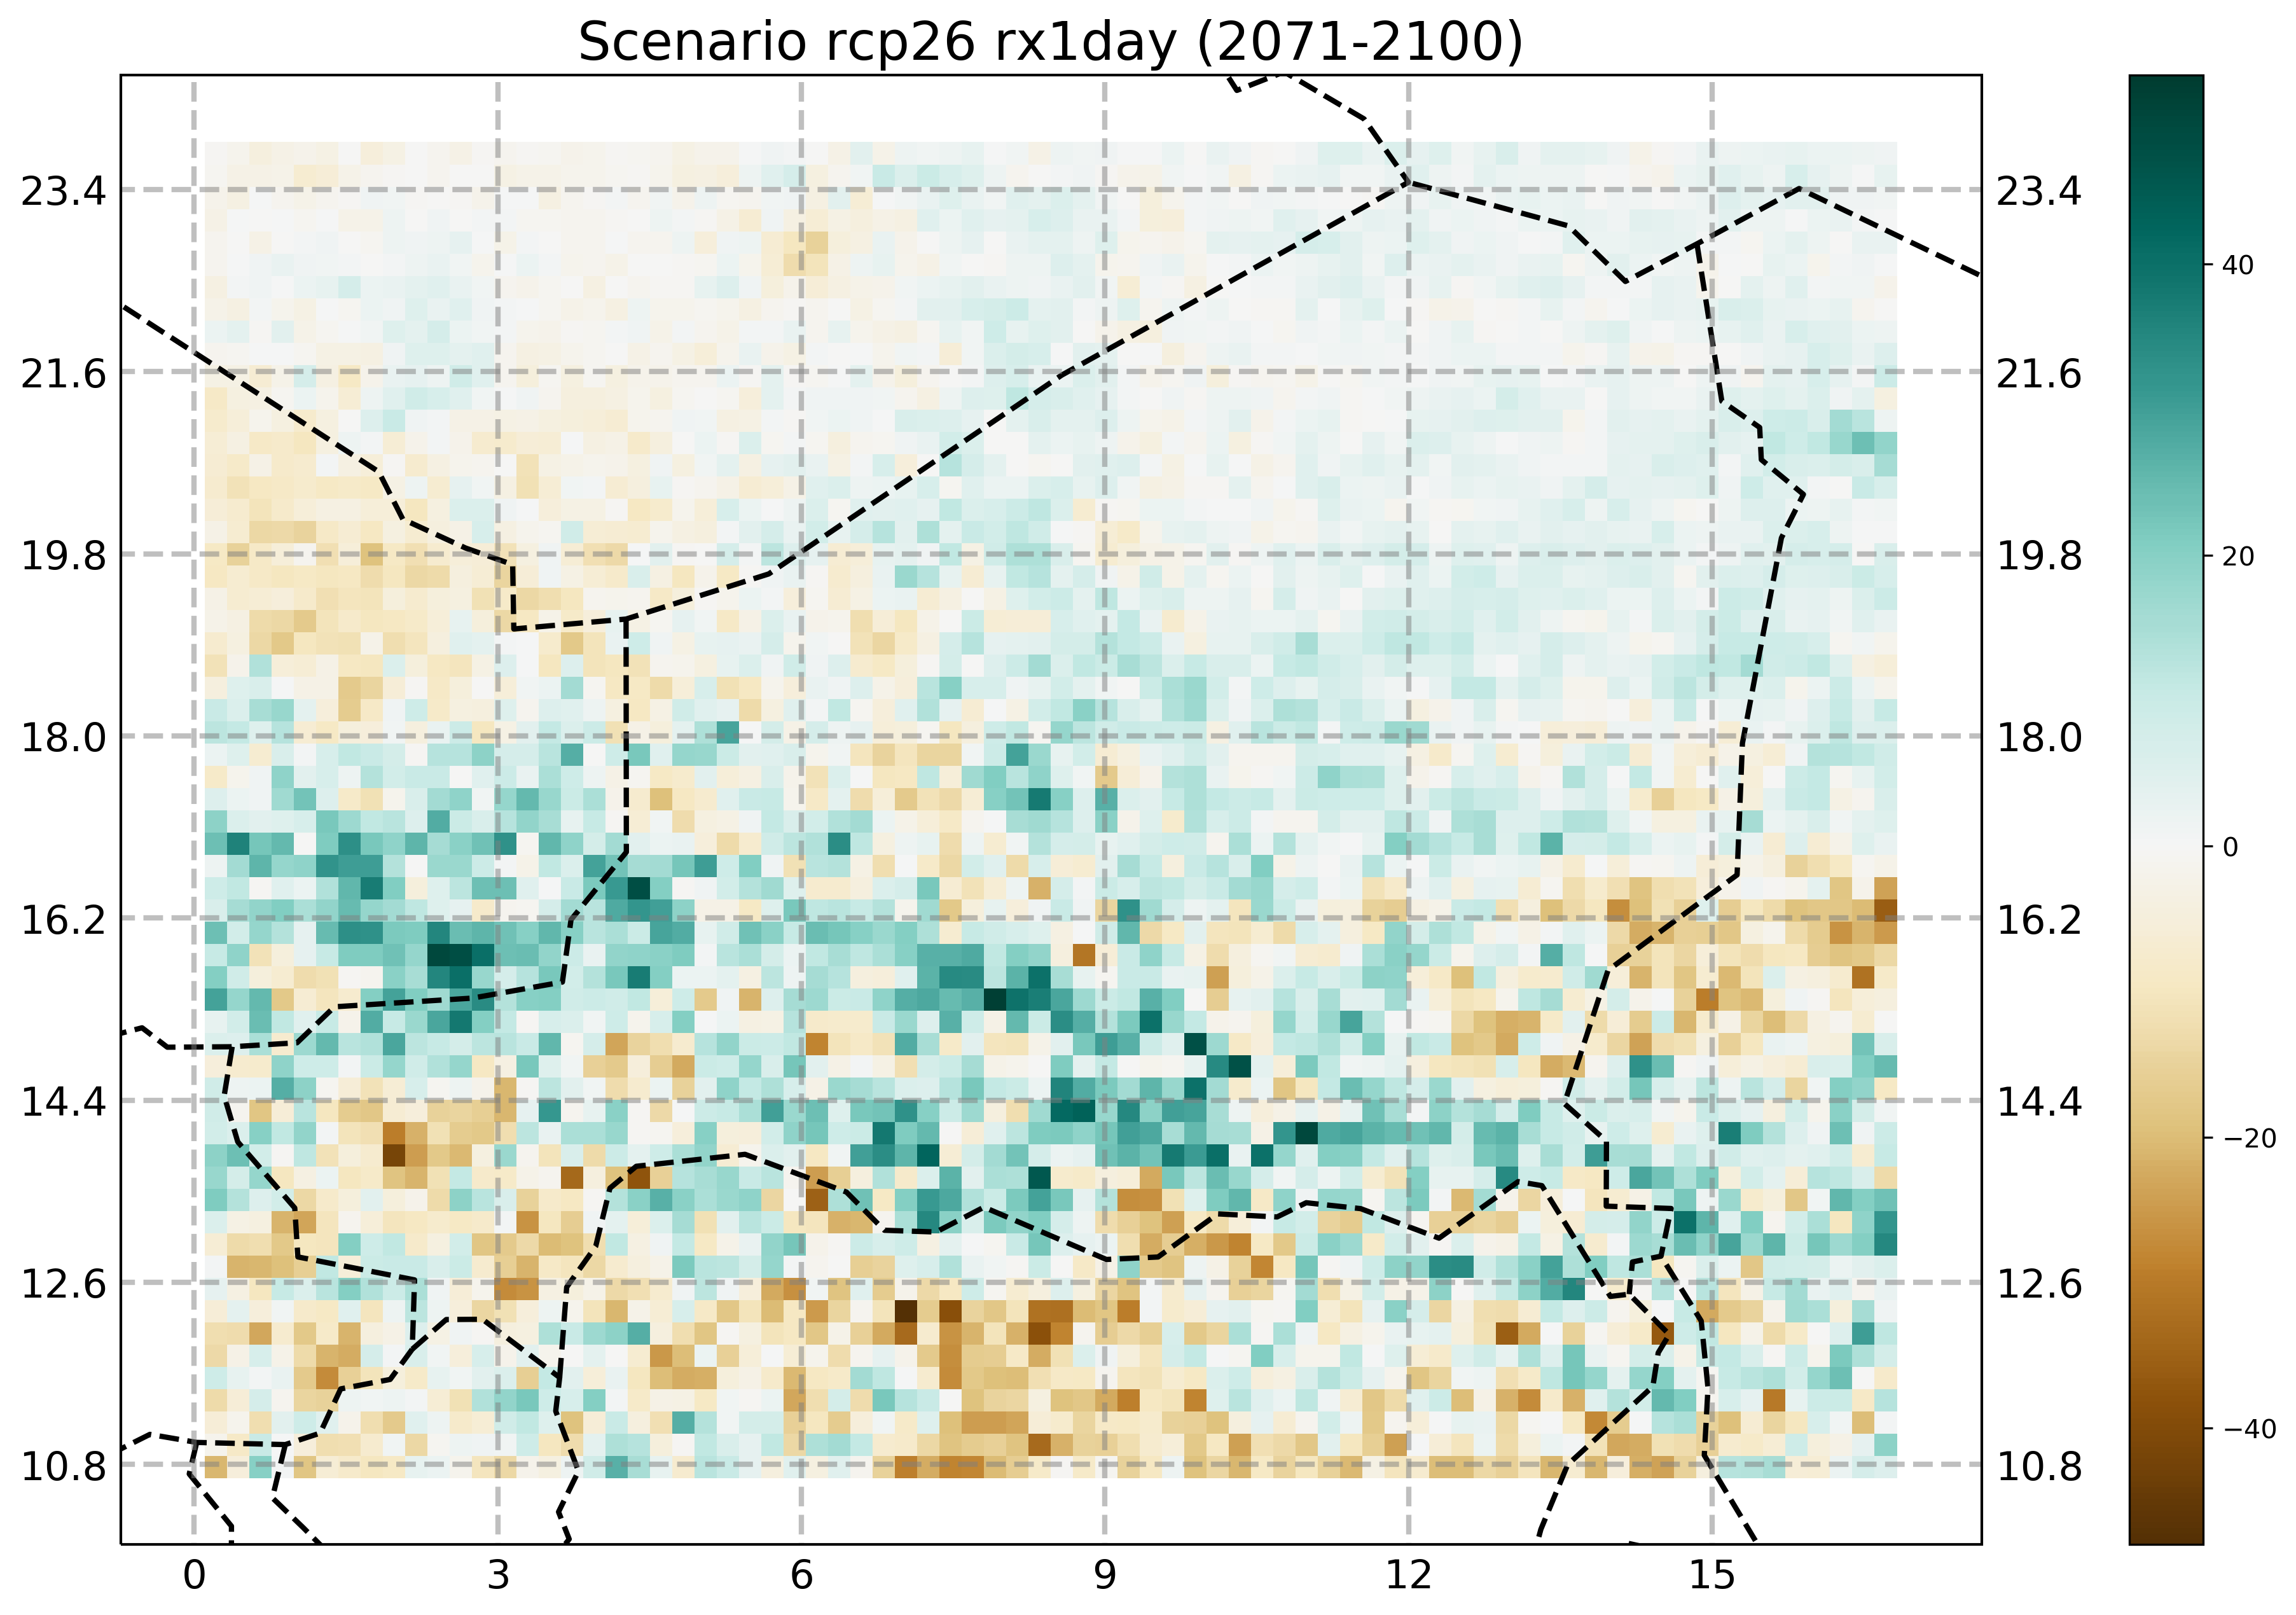

In [28]:
Image(out.get()[2], width=600)